In [1]:
import scipy
import pandas as pd
import numpy as np
from collections import Counter
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats

# Normality Check --- Shapiro-wilk Test

In [2]:
def normality_check(dataset):
# shapiro_table = FF.create_table(x_ortho, index=True)

    shapiro_results = scipy.stats.shapiro(dataset)

    sw =[
        ['', 'DF', 'Test Statistic', 'p-value'],
        ['Sample Data', len(dataset) - 1, shapiro_results[0], shapiro_results[1]]
    ]
    normcheck = pd.DataFrame(sw)
    header = normcheck.iloc[0]
    normcheck = normcheck[1:]
    normcheck.rename(columns = header)
    
    if normcheck.iloc[0,3] <= 0.05:
        print('Data is normally distributed')
    else:
        print('Data needs to be transformed')

# MR Chart

In [3]:
def MR_i(dataset):
    MRi = []
    for x in range(len(dataset)-1):
        MRi.append(np.abs(dataset['Overall Duration'].iloc[x]-dataset['Overall Duration'].iloc[x+1]))
        MR = np.mean(MRi)
    return MRi, MR

In [4]:
def control_limits(MR):
    d2 = 1.128
    x_bar = dataset.mean()
    sigma = MR / d2
    LCL = sigma * 0.044319
    UCL = sigma * 3.169822
    Centre = MR
    return UCL, LCL, Centre, sigma

In [5]:
def MRchart(LCL, UCL, Centre):
    d = np.array(MRi)/60
    plot = plt.axhline(y=LCL/60, color='b', linestyle='-')
    plot = plt.axhline(y=UCL/60, color='b', linestyle='-')
    plot = plt.axhline(y=Centre/60, color = 'r', linestyle = '--')
   
    plot = plt.plot(x_axis, d, marker = '.', color = 'k')
    
    plot = plt.title(title)
    plot = plt.xlabel('Pick order')
    plot = plt.ylabel('Overall Duration (min)')
#     plt.show()

In [6]:
def check_outlier(MRi, UCL, LCL):
    outlier = []
    idx = []
    for i in range(len(MRi)):
        if ((MRi[i] > UCL) | (MRi[i] < LCL)):
            outlier.append(MRi[i])
            idx.append(i)            
            
    return outlier, idx

In [7]:
def remove_outlier(outlier, idx):
    for j in idx:
        c1 = np.abs(dataset['Overall Duration'].iloc[j+1] > dataset['Overall Duration'].iloc[j-1])
        c2 = np.abs(dataset['Overall Duration'].iloc[j] > dataset['Overall Duration'].iloc[j+2])
        if c1 <= c2:
            dataset_temp = dataset.drop(dataset.index[j])
        else:
            dataset_temp = dataset.drop(dataset.index[j+1])           
    return dataset_temp

# I chart

In [8]:
def I_control_limits(MR, sigma): 
    d2 = 1.128
    z = 1.96 #95% CI
    x_bar = np.mean(dataset['Overall Duration'].tolist())
    UCL = x_bar + z * sigma
    LCL = x_bar - z * sigma
    Centre = x_bar

    return UCL, LCL, Centre

In [9]:
def Ichart(LCL, UCL, Centre):
    d = np.array(dataset['Overall Duration'])/60
    plt.axhline(y=LCL/60, color='b', linestyle='-')
    plt.axhline(y=UCL/60, color='b', linestyle='-')
    plt.axhline(y=Centre/60, color = 'r', linestyle = '--')
    
    plt.plot(x_axis, d, marker = '.', color = 'k')
    plt.title(title)
    plt.xlabel('Pick order')
    plt.ylabel('Overall Duration (min)')
#     plt.show()

In [10]:
def I_check_outlier(MRi, UCL, LCL):
    outlier = []
    idx = []
    for i in range(len(dataset)):
        if ((dataset['Overall Duration'].tolist()[i] > UCL) | (dataset['Overall Duration'].tolist()[i] < LCL)):
            outlier.append(dataset['Overall Duration'].tolist()[i])
            idx.append(i)                       
    return outlier, idx

In [11]:
def I_remove_outlier(outlier, idx):
    for j in idx:
            dataset_temp = dataset.drop(dataset.index[j])         
    return dataset_temp

# Data Analysis

In [12]:
df = pd.read_csv('Raw Data.csv', index_col = 0)

In [13]:
def duration_to_sec(s):
    if (s != '-' ):
        temp = s.split(':')
        sec = float(temp[0])*60 + float(temp[1])
    else:
        sec = np.nan
    return sec

In [14]:
df = df.drop(['Unnamed: 13'],axis = 1)

In [15]:
df.drop(df.columns[[9,11]], axis = 1,inplace=True)

In [16]:
df = df.reset_index().set_index(['OR case #'])

In [17]:
#list of columns names
columns = df.columns

In [18]:
df = df.rename(columns={'Pick start time (From when staff starts looking at Pick Sheet)': 'Start Time', 
                        'Pick duration for disposable in [mm:ss] (Optional)': 'Disposable Duration',
                        'Pick duration for all in [mm:ss] \n(Stop the stopwatch when staff parks cart)': 
                        'Overall Duration',
                        'Distractions [mm:ss]': 'Distractions'
                       }
              )

In [19]:
df['Disposable Duration'] = df['Disposable Duration'].apply(duration_to_sec)
df['Overall Duration'] = df['Overall Duration'].apply(duration_to_sec)
df['Distractions'] = df['Distractions'].apply(duration_to_sec)

In [20]:
df = df.drop(df[df['Distractions'].notnull()].index)

In [21]:
dataset = df['Overall Duration']
normality_check(dataset)

Data is normally distributed


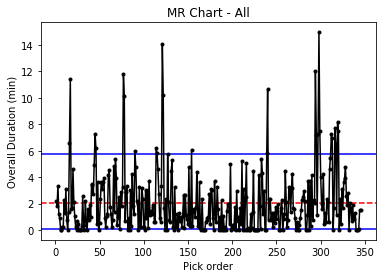

In [22]:
dataset = dataset.reset_index()
title = 'MR Chart - All'
#x-axis
MRi = MR_i(dataset)[0]
MR = MR_i(dataset)[1]
x_axis = np.arange(1,len(MRi)+1,1)

limits = control_limits(MR)
sigma = limits[3]
plot = MRchart(limits[0],limits[1],limits[2])
UCL = limits[0]
LCL = limits[1]
Centre = limits[2]

In [23]:
outlier_value, outlier_idx = check_outlier(MRi, UCL, LCL)
if len(outlier_idx) != 0:
    dataset = remove_outlier(outlier_value, outlier_idx)

The MR chart went through 86 iterations, no more outliers!


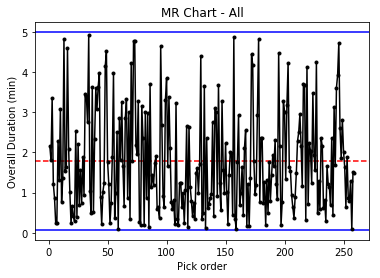

In [24]:
count = 0
while(len(outlier_value) > 0):
    plt.clf()
    count += 1
    #x-axis
    dataset = dataset.reset_index(drop = True)
    MRi, MR = MR_i(dataset)

    x_axis = np.arange(1,len(MRi)+1,1)

    limits = control_limits(MR)
    plot = MRchart(limits[0],limits[1],limits[2])
    UCL = limits[0]
    LCL = limits[1]
    Centre = limits[2]

    outlier_value, outlier_idx = check_outlier(MRi, UCL, LCL)
    if (len(outlier_idx) != 0):
        dataset = remove_outlier(outlier_value, outlier_idx)

print('The MR chart went through ' + str(count) + ' iterations, no more outliers!')
plt.savefig('MR Chart - All')

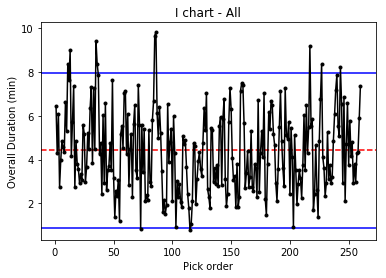

In [25]:
title = 'I chart - All'
#x-axis
x_axis = np.arange(1,len(dataset)+1,1)

limits = I_control_limits(MR, sigma)
UCL = limits[0]
LCL = limits[1]
Centre = limits[2]
Ichart(LCL, UCL, Centre)

In [26]:
outlier_value, outlier_idx = I_check_outlier(MRi, UCL, LCL)
if len(outlier_idx) != 0:
    dataset = I_remove_outlier(outlier_value, outlier_idx)

The I chart went through 12 iterations, no more outliers!


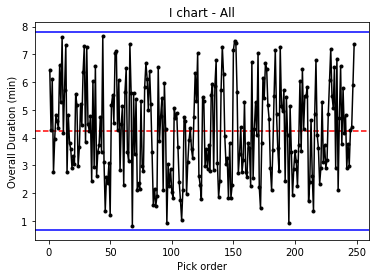

In [27]:
count = 0
while(len(outlier_value) > 0):
    plt.clf()
    count += 1
    #x-axis
    dataset = dataset.reset_index(drop = True)
    MRi, MR = MR_i(dataset)

    x_axis = np.arange(1,len(dataset)+1,1)

    limits = I_control_limits(MR, sigma)
    UCL = limits[0]
    LCL = limits[1]
    Centre = limits[2]
    plot = Ichart(LCL, UCL, Centre)

    outlier_value, outlier_idx = I_check_outlier(MRi, UCL, LCL)
    if len(outlier_idx) != 0:
        dataset = I_remove_outlier(outlier_value, outlier_idx)
print('The I chart went through ' + str(count) + ' iterations, no more outliers!')
plt.savefig('I chart - All')

# Surgical Specialty -- Ortho

In [28]:
ortho = df[(df['Surgical Specialty'] == 'Ortho')]
ortho = ortho.reset_index().set_index('OR case #')

In [29]:
duplicate_ortho = ortho[ortho.duplicated(['Start Time', 'Disposable Duration', 'Overall Duration'], keep = False)]
duplicate_ortho

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,


In [30]:
#drop duplicates in original dataset
ortho = ortho.drop(duplicate_ortho.index)
ortho.head()

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,
GOR-2018-7386,2018/6/5,Nathan,B,> 20 Years,Emergency,Ortho,7:58 AM,NaN,387.0,NaN
GOR-2018-7421,2018/6/5,Nathan,B,> 20 Years,Emergency,Ortho,11:15 AM,179.0,275.0,NaN
GOR-2018-6930,2018/6/8,Christina,Cecilia,20 Years,Elective,Ortho,12:55 PM,99.0,397.0,NaN
GOR-2018-7426,2018/6/5,Nathan,B,> 20 Years,Emergency,Ortho,12:42 PM,103.0,318.0,NaN
GOR-2018-7430,2018/6/5,Nathan,B,> 20 Years,Emergency,Ortho,2:04 PM,162.0,539.0,NaN


In [31]:
#number of duplicates in a given day and start time
ortho_count = duplicate_ortho.groupby(['Date','Start Time'])['Disposable Duration','Overall Duration'].count()
ortho_count = ortho_count.reset_index().drop(['Disposable Duration'], axis = 1)
ortho_count = ortho_count.rename(columns={'Overall Duration': 'Counts'})
ortho_count

,Date,Start Time,Counts


In [32]:
duplicate_ortho = duplicate_ortho.drop_duplicates(keep = 'first')
duplicate_ortho

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,


In [33]:
for i in range(len(ortho_count['Counts'])):
    for j in range(len(duplicate_ortho['Overall Duration'])):
        if ortho_count['Date'][i] == duplicate_ortho['Date'][j] and ortho_count['Start Time'][i] == duplicate_ortho['Start Time'][j]:
            duplicate_ortho['Disposable Duration'][j] /= ortho_count['Counts'][i]
            duplicate_ortho['Overall Duration'][j] /= ortho_count['Counts'][i]

In [34]:
duplicate_ortho

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,


In [35]:
ortho = pd.concat([ortho, duplicate_ortho],axis = 0)

In [36]:
ortho.tail()

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,
GOR-2018-8688,2018/7/6,Nathan,Ella,> 20 Years,Emergency,Ortho,7:11 AM,171.0,347.0,NaN
GOR-2018-8689,2018/7/6,Nathan,Ella,> 20 Years,Emergency,Ortho,7:18 AM,88.0,249.0,NaN
GOR-2018-6387,2018/7/6,Nathan,Ella,> 20 Years,Elective,Ortho,10:47 AM,119.0,288.0,NaN
GOR-2018-8674,2018/7/6,Nathan,Ella,> 20 Years,Elective,Ortho,10:53 AM,72.0,175.0,NaN
GOR-2018-8601,2018/7/6,Nathan,Ella,> 20 Years,elective,Ortho,11:40 AM,139.0,442.0,NaN


## MR Chart

In [37]:
dataset = ortho['Overall Duration']
normality_check(dataset)

Data is normally distributed


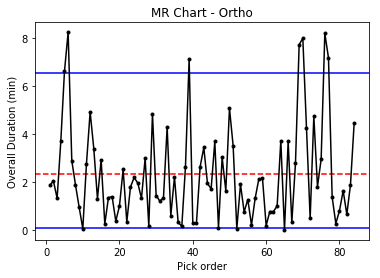

In [38]:
title = 'MR Chart - Ortho'
dataset = dataset.reset_index()
#x-axis
MRi = MR_i(dataset)[0]
MR = MR_i(dataset)[1]
x_axis = np.arange(1,len(MRi)+1,1)

limits = control_limits(MR)
plot = MRchart(limits[0],limits[1],limits[2])
UCL = limits[0]
LCL = limits[1]
Centre = limits[2]

In [39]:
outlier_value, outlier_idx = check_outlier(MRi, UCL, LCL)
if len(outlier_idx) != 0:
    dataset = remove_outlier(outlier_value, outlier_idx)

The MR chart went through 9 iterations, no more outliers!


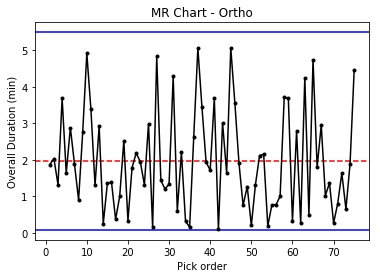

In [40]:
count = 0
while(len(outlier_value) > 0):
    plt.clf()
    count += 1
    #x-axis
    dataset = dataset.reset_index(drop = True)
    MRi, MR = MR_i(dataset)
    #MR = MR_i(dataset)[1]
    x_axis = np.arange(1,len(MRi)+1,1)

    limits = control_limits(MR)
    plot = MRchart(limits[0],limits[1],limits[2])
    UCL = limits[0]
    LCL = limits[1]
    Centre = limits[2]

    outlier_value, outlier_idx = check_outlier(MRi, UCL, LCL)
    if (len(outlier_idx) != 0):
        dataset = remove_outlier(outlier_value, outlier_idx)
print('The MR chart went through ' + str(count) + ' iterations, no more outliers!')
plt.savefig('MR chart - Ortho')

## I Chart

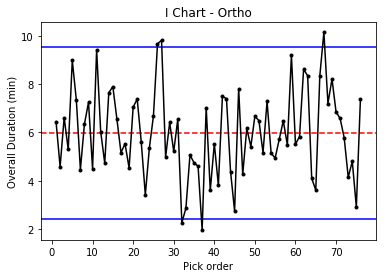

In [41]:
title = 'I Chart - Ortho'
#x-axis
x_axis = np.arange(1,len(dataset)+1,1)

limits = I_control_limits(MR, sigma)
UCL = limits[0]
LCL = limits[1]
Centre = limits[2]
plot = Ichart(LCL, UCL, Centre)

In [42]:
outlier_value, outlier_idx = I_check_outlier(MRi, UCL, LCL)
if len(outlier_idx) != 0:
    dataset = I_remove_outlier(outlier_value, outlier_idx)

The I chart went through 5 iterations, no more outliers!


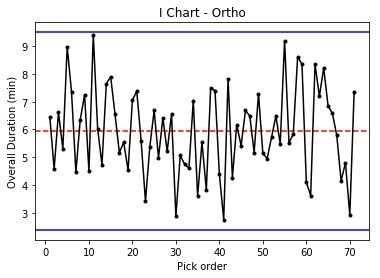

In [43]:
count = 0
while(len(outlier_value) > 0):
    plt.clf()
    count += 1
    #x-axis
    dataset = dataset.reset_index(drop = True)
    MRi, MR = MR_i(dataset)

    x_axis = np.arange(1,len(dataset)+1,1)

    limits = I_control_limits(MR, sigma)
    UCL = limits[0]
    LCL = limits[1]
    Centre = limits[2]
    plot = Ichart(LCL, UCL, Centre)

    outlier_value, outlier_idx = I_check_outlier(MRi, UCL, LCL)
    if len(outlier_idx) != 0:
        dataset = I_remove_outlier(outlier_value, outlier_idx)
print('The I chart went through ' + str(count) + ' iterations, no more outliers!')
plt.savefig('I chart - Ortho')

In [44]:
dataset_ortho_final = dataset
dataset_ortho_final.head()

,OR case #,Overall Duration
0,GOR-2018-7386,387.0
1,GOR-2018-7421,275.0
2,GOR-2018-6930,397.0
3,GOR-2018-7426,318.0
4,GOR-2018-7430,539.0


# Surgical Specialty -- General Surgery# 

In [45]:
GS = df[(df['Surgical Specialty'] == 'General Surgery')]
GS.head()

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,
GOR-2018-6929,2018/6/8,Christina,Cecilia,20 Years,Elective,General Surgery,10:41 AM,257.0,257.0,NaN
GOR-2018-7414,2018/6/5,Jialin,B,> 20 Years,Emergency,General Surgery,10:32 AM,88.0,165.0,NaN
GOR-2018-7082,2018/6/8,Christina,Cecilia,20 Years,Elective,General Surgery,11:00 AM,132.0,238.0,NaN
GOR-2018-7420,2018/6/5,Nathan,B,> 20 Years,Emergency,General Surgery,11:24 AM,216.0,260.0,NaN
GOR-2018-7453,2018/6/6,Haya,C,20 years,Emergency,General Surgery,10:49 AM,133.0,165.0,NaN


In [46]:
duplicate_GS = GS[GS.duplicated(['Start Time', 'Disposable Duration', 'Overall Duration'], keep = False)]
duplicate_GS

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,
GOR-2018-8626,2018/7/5,Emma,Elaine,> 20 Years,Emergency,General Surgery,8:28 AM,305.0,473.0,NaN
GOR-2018-8628,2018/7/5,Emma,Elaine,> 20 Years,Emergency,General Surgery,8:28 AM,305.0,473.0,NaN


In [47]:
#drop duplicates in original dataset
GS = GS.drop(duplicate_GS.index)
GS.head()

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,
GOR-2018-6929,2018/6/8,Christina,Cecilia,20 Years,Elective,General Surgery,10:41 AM,257.0,257.0,NaN
GOR-2018-7414,2018/6/5,Jialin,B,> 20 Years,Emergency,General Surgery,10:32 AM,88.0,165.0,NaN
GOR-2018-7082,2018/6/8,Christina,Cecilia,20 Years,Elective,General Surgery,11:00 AM,132.0,238.0,NaN
GOR-2018-7420,2018/6/5,Nathan,B,> 20 Years,Emergency,General Surgery,11:24 AM,216.0,260.0,NaN
GOR-2018-7453,2018/6/6,Haya,C,20 years,Emergency,General Surgery,10:49 AM,133.0,165.0,NaN


In [48]:
#number of duplicates in a given day and start time
GS_count = duplicate_GS.groupby(['Date','Start Time'])['Disposable Duration','Overall Duration'].count()
GS_count = GS_count.reset_index().drop(['Disposable Duration'], axis = 1)
GS_count = GS_count.rename(columns={'Overall Duration': 'Counts'})
GS_count

,Date,Start Time,Counts
0,2018/7/5,8:28 AM,2


In [49]:
duplicate_GS = duplicate_GS.drop_duplicates(keep = 'first')
duplicate_GS

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,
GOR-2018-8626,2018/7/5,Emma,Elaine,> 20 Years,Emergency,General Surgery,8:28 AM,305.0,473.0,NaN


In [50]:
for i in range(len(GS_count['Counts'])):
    for j in range(len(duplicate_GS['Overall Duration'])):
        if GS_count['Date'][i] == duplicate_GS['Date'][j] and GS_count['Start Time'][i] == duplicate_GS['Start Time'][j]:
            duplicate_GS['Disposable Duration'][j] /= GS_count['Counts'][i]
            duplicate_GS['Overall Duration'][j] /= GS_count['Counts'][i]

/Users/jiajialin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/jiajialin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/jiajialin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [51]:
duplicate_GS

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,
GOR-2018-8626,2018/7/5,Emma,Elaine,> 20 Years,Emergency,General Surgery,8:28 AM,152.5,236.5,NaN


In [52]:
GS = pd.concat([GS, duplicate_GS],axis = 0)

In [53]:
GS.tail(1)

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,
GOR-2018-8626,2018/7/5,Emma,Elaine,> 20 Years,Emergency,General Surgery,8:28 AM,152.5,236.5,NaN


In [54]:
dataset = GS['Overall Duration']
normality_check(dataset)

Data is normally distributed


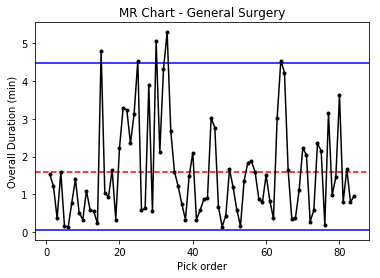

In [55]:
title = 'MR Chart - General Surgery'
dataset = dataset.reset_index()
#x-axis
MRi = MR_i(dataset)[0]
MR = MR_i(dataset)[1]
x_axis = np.arange(1,len(MRi)+1,1)

limits = control_limits(MR)
plot = MRchart(limits[0],limits[1],limits[2])
UCL = limits[0]
LCL = limits[1]
Centre = limits[2]

In [56]:
outlier_value, outlier_idx = check_outlier(MRi, UCL, LCL)
if len(outlier_idx) != 0:
    dataset = remove_outlier(outlier_value, outlier_idx)

The MR chart went through 9 iterations, no more outliers!


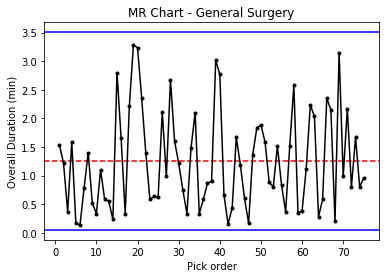

In [57]:
count = 0
while(len(outlier_value) > 0):
    plt.clf()
    count += 1
    #x-axis
    dataset = dataset.reset_index(drop = True)
    MRi, MR = MR_i(dataset)
    #MR = MR_i(dataset)[1]
    x_axis = np.arange(1,len(MRi)+1,1)

    limits = control_limits(MR)
    plot = MRchart(limits[0],limits[1],limits[2])
    UCL = limits[0]
    LCL = limits[1]
    Centre = limits[2]

    outlier_value, outlier_idx = check_outlier(MRi, UCL, LCL)
    if (len(outlier_idx) != 0):
        dataset = remove_outlier(outlier_value, outlier_idx)
print('The MR chart went through ' + str(count) + ' iterations, no more outliers!')
plt.savefig('MR Chart - General Surgery')

## I Chart

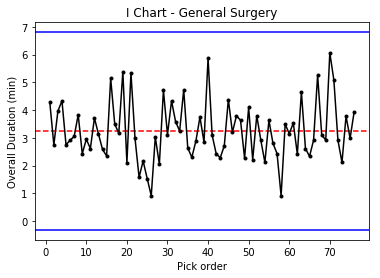

In [58]:
title = 'I Chart - General Surgery'
#x-axis
x_axis = np.arange(1,len(dataset)+1,1)

limits = I_control_limits(MR, sigma)
UCL = limits[0]
LCL = limits[1]
Centre = limits[2]
plot = Ichart(LCL, UCL, Centre)
plt.savefig('I Chart - General Surgery')

In [59]:
outlier_value, outlier_idx = I_check_outlier(MRi, UCL, LCL)
if len(outlier_idx) != 0:
    dataset = I_remove_outlier(outlier_value, outlier_idx)

In [60]:
count = 0
while(len(outlier_value) > 0):  
    plt.clf()
    count += 1
    #x-axis
    dataset = dataset.reset_index(drop = True)
    MRi, MR = MR_i(dataset)

    x_axis = np.arange(1,len(dataset)+1,1)

    limits = I_control_limits(MR, sigma)
    UCL = limits[0]
    LCL = limits[1]
    Centre = limits[2]
    plot = Ichart(LCL, UCL, Centre)

    outlier_value, outlier_idx = I_check_outlier(MRi, UCL, LCL)
    if len(outlier_idx) != 0:
        dataset = I_remove_outlier(outlier_value, outlier_idx)
print('The I chart went through ' + str(count) + ' iterations, no more outliers!')
# plt.savefig('I chart - General Surgery')

The I chart went through 0 iterations, no more outliers!


In [61]:
dataset_GS_final = dataset
dataset_GS_final.head()

,OR case #,Overall Duration
0,GOR-2018-6929,257.0
1,GOR-2018-7414,165.0
2,GOR-2018-7082,238.0
3,GOR-2018-7420,260.0
4,GOR-2018-7453,165.0


# Surgical Specialty -- Dental

In [62]:
dental = df[(df['Surgical Specialty'] == 'Dental')
            |(df['Surgical Specialty'] == 'dental')
           ]
dental.head()

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,
GOR-2018-6116,2018/6/8,Christina,Cecilia,20 Years,Elective,Dental,10:53 AM,165.0,366.0,NaN
GOR-2018-5735,2018/6/8,Christina,Cecilia,20 Years,Elective,Dental,1:12 PM,NaN,457.0,NaN
GOR-2018-5696,2018/6/8,Christina,Cecilia,20 Years,Elective,Dental,1:12 PM,NaN,457.0,NaN
GOR-2018-7809,2018/6/18,Christina,Plenamin,15 Years,Elective,Dental,3:25 PM,85.0,200.0,NaN
GOR-2018-7378,2018/6/18,Christina,Plenamin,15 Years,Elective,Dental,3:25 PM,85.0,200.0,NaN


In [63]:
duplicate_dental = dental[dental.duplicated(['Start Time', 'Disposable Duration', 'Overall Duration'], keep = False)]
duplicate_dental

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,
GOR-2018-5735,2018/6/8,Christina,Cecilia,20 Years,Elective,Dental,1:12 PM,NaN,457.0,NaN
GOR-2018-5696,2018/6/8,Christina,Cecilia,20 Years,Elective,Dental,1:12 PM,NaN,457.0,NaN
GOR-2018-7809,2018/6/18,Christina,Plenamin,15 Years,Elective,Dental,3:25 PM,85.0,200.0,NaN
GOR-2018-7378,2018/6/18,Christina,Plenamin,15 Years,Elective,Dental,3:25 PM,85.0,200.0,NaN
GOR-2018-7915,2018/6/18,Christina,Plenamin,15 Years,Elective,Dental,3:25 PM,85.0,200.0,NaN
GOR-2018-6262,2018/6/18,Christina,Plenamin,15 Years,Elective,Dental,3:25 PM,85.0,200.0,NaN
GOR-2018-7501,2018/6/25,Jialin,Plenamin,15 Years,elective,dental,3:03,94.0,211.0,NaN
GOR-2018-7383,2018/6/25,Jialin,Plenamin,15 Years,elective,dental,3:03,94.0,211.0,NaN
GOR-2018-3645,2018/6/25,Jialin,Plenamin,15 Years,elective,dental,3:03,94.0,211.0,NaN


In [64]:
#drop duplicates in original dataset
dental = dental.drop(duplicate_dental.index)
dental.head()

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,
GOR-2018-6116,2018/6/8,Christina,Cecilia,20 Years,Elective,Dental,10:53 AM,165.0,366.0,NaN
GOR-2018-7151,2018/7/4,Christina,Plenamin,15 Years,elective,dental,3:12 PM,NaN,395.0,NaN
GOR-2018-6699,2018/6/15,Emma,Elaine,15 years,Elective,Dental,11:34 AM,290.0,878.0,NaN
GOR-2018-,2018/6/13,Haya,Egna,>5 years (Part-time),elective,dental,4:22,NaN,380.0,NaN
GOR-2018-7102,2018/6/20,Haya,Ella,> 20 Years,elective,dental,11:44,98.0,167.0,NaN


In [65]:
#number of duplicates in a given day and start time
dental_count = duplicate_dental.groupby(['Date','Start Time'])['Disposable Duration','Overall Duration'].count()
dental_count = dental_count.reset_index().drop(['Disposable Duration'], axis = 1)
dental_count = dental_count.rename(columns={'Overall Duration': 'Counts'})
dental_count

,Date,Start Time,Counts
0,2018/6/18,3:25 PM,4
1,2018/6/25,3:03,3
2,2018/6/8,1:12 PM,2


In [66]:
duplicate_dental = duplicate_dental.drop_duplicates(keep = 'first')
duplicate_dental

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,
GOR-2018-5735,2018/6/8,Christina,Cecilia,20 Years,Elective,Dental,1:12 PM,NaN,457.0,NaN
GOR-2018-7809,2018/6/18,Christina,Plenamin,15 Years,Elective,Dental,3:25 PM,85.0,200.0,NaN
GOR-2018-7501,2018/6/25,Jialin,Plenamin,15 Years,elective,dental,3:03,94.0,211.0,NaN


In [67]:
for i in range(len(dental_count['Counts'])):
    for j in range(len(duplicate_dental['Overall Duration'])):
        if dental_count['Date'][i] == duplicate_dental['Date'][j] and dental_count['Start Time'][i] == duplicate_dental['Start Time'][j]:
            duplicate_dental['Disposable Duration'][j] /= dental_count['Counts'][i]
            duplicate_dental['Overall Duration'][j] /= dental_count['Counts'][i]

/Users/jiajialin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/jiajialin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/jiajialin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [68]:
duplicate_dental

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,
GOR-2018-5735,2018/6/8,Christina,Cecilia,20 Years,Elective,Dental,1:12 PM,NaN,228.500000,NaN
GOR-2018-7809,2018/6/18,Christina,Plenamin,15 Years,Elective,Dental,3:25 PM,21.250000,50.000000,NaN
GOR-2018-7501,2018/6/25,Jialin,Plenamin,15 Years,elective,dental,3:03,31.333333,70.333333,NaN


In [69]:
dental = pd.concat([dental, duplicate_dental],axis = 0)

In [70]:
dataset = dental['Overall Duration']
normality_check(dataset)

Data needs to be transformed


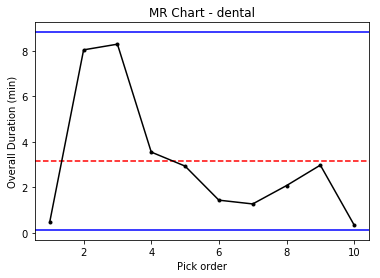

In [71]:
title = 'MR Chart - dental'
dataset = dataset.reset_index()
#x-axis
MRi = MR_i(dataset)[0]
MR = MR_i(dataset)[1]
x_axis = np.arange(1,len(MRi)+1,1)

limits = control_limits(MR)
plot = MRchart(limits[0],limits[1],limits[2])
UCL = limits[0]
LCL = limits[1]
Centre = limits[2]
plt.savefig('MR Chart - Dental')

In [72]:
outlier_value, outlier_idx = check_outlier(MRi, UCL, LCL)
if len(outlier_idx) != 0:
    dataset = remove_outlier(outlier_value, outlier_idx)

In [73]:
count = 0
while(len(outlier_value) > 0):
    plt.clf()
    count += 1
    #x-axis
    dataset = dataset.reset_index(drop = True)
    MRi, MR = MR_i(dataset)
    #MR = MR_i(dataset)[1]
    x_axis = np.arange(1,len(MRi)+1,1)

    limits = control_limits(MR)
    plot = MRchart(limits[0],limits[1],limits[2])
    UCL = limits[0]
    LCL = limits[1]
    Centre = limits[2]

    outlier_value, outlier_idx = check_outlier(MRi, UCL, LCL)
    if (len(outlier_idx) != 0):
        dataset = remove_outlier(outlier_value, outlier_idx)
print('The MR chart went through ' + str(count) + ' iterations, no more outliers!')
# plt.savefig('MR Chart - Dental')

The MR chart went through 0 iterations, no more outliers!


## I Chart

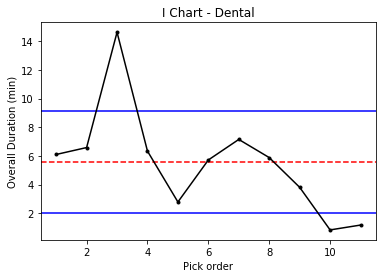

In [74]:
title = 'I Chart - Dental'
#x-axis
x_axis = np.arange(1,len(dataset)+1,1)

limits = I_control_limits(MR, sigma)
UCL = limits[0]
LCL = limits[1]
Centre = limits[2]
Ichart(LCL, UCL, Centre)

In [75]:
outlier_value, outlier_idx = I_check_outlier(MRi, UCL, LCL)
if len(outlier_idx) != 0:
    dataset = I_remove_outlier(outlier_value, outlier_idx)


The I chart went through 4 iterations, no more outliers!


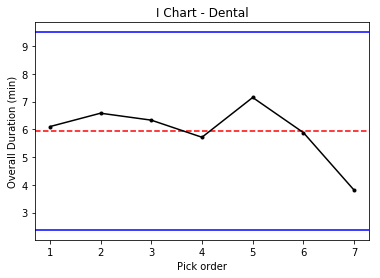

In [76]:
count = 0
while(len(outlier_value) > 0):  
    plt.clf()
    count += 1
    #x-axis
    dataset = dataset.reset_index(drop = True)
    MRi, MR = MR_i(dataset)

    x_axis = np.arange(1,len(dataset)+1,1)

    limits = I_control_limits(MR, sigma)
    UCL = limits[0]
    LCL = limits[1]
    Centre = limits[2]
    plot = Ichart(LCL, UCL, Centre)

    outlier_value, outlier_idx = I_check_outlier(MRi, UCL, LCL)
    if len(outlier_idx) != 0:
        dataset = I_remove_outlier(outlier_value, outlier_idx)        
print('The I chart went through ' + str(count) + ' iterations, no more outliers!')
plt.savefig('I chart - Dental')

In [77]:
dataset_ortho_final = dataset
dataset_ortho_final.head()

,OR case #,Overall Duration
0,GOR-2018-6116,366.0
1,GOR-2018-7151,395.0
2,GOR-2018-,380.0
3,GOR-2018-7110,343.0
4,GOR-2018-6302,429.0


# Surgical Specialty -- ENT

In [78]:
ent = df[(df['Surgical Specialty'] == 'ent')
         | (df['Surgical Specialty'] == 'ENT')]
ent.head()

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,
GOR-2018-6817,2018/6/8,Christina,Cecilia,20 Years,Elective,ENT,11:14 AM,134.0,290.0,NaN
GOR-2018-6811,2018/6/8,Christina,Cecilia,20 Years,Elective,ENT,11:14 AM,134.0,290.0,NaN
GOR-2018-6179,2018/6/8,Christina,Cecilia,20 Years,Elective,ENT,11:14 AM,134.0,290.0,NaN
GOR-2018-7621,2018/6/18,Christina,Plenamin,15 Years,Elective,ENT,3:42 PM,207.0,335.0,NaN
GOR-2018-8193,2018/7/4,Christina,Plenamin,15 Years,elective,ENT,3:25 PM,NaN,210.0,NaN


In [79]:
duplicate_ent = ent[ent.duplicated(['Start Time', 'Disposable Duration', 'Overall Duration'], keep = False)]
duplicate_ent.head()

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,
GOR-2018-6817,2018/6/8,Christina,Cecilia,20 Years,Elective,ENT,11:14 AM,134.0,290.0,NaN
GOR-2018-6811,2018/6/8,Christina,Cecilia,20 Years,Elective,ENT,11:14 AM,134.0,290.0,NaN
GOR-2018-6179,2018/6/8,Christina,Cecilia,20 Years,Elective,ENT,11:14 AM,134.0,290.0,NaN
GOR-2018-8193,2018/7/4,Christina,Plenamin,15 Years,elective,ENT,3:25 PM,NaN,210.0,NaN
GOR-2018-8194,2018/7/4,Christina,Plenamin,15 Years,elective,ENT,3:25 PM,NaN,210.0,NaN


In [80]:
#drop duplicates in original dataset
ent = ent.drop(duplicate_ent.index)
ent.head()

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,
GOR-2018-7621,2018/6/18,Christina,Plenamin,15 Years,Elective,ENT,3:42 PM,207.0,335.0,NaN
GOR-2018-7141,2018/6/5,Emma,Ann,> 20 Years,Elective,ENT,3:13 PM,82.0,82.0,NaN
GOR-2018-7761,2018/6/12,Nathan,Cecilia,20 Years,Emergency,ent,12:59 PM,161.0,269.0,NaN
GOR-2018-7542,2018/6/15,Emma,Ann,> 20 Years,Elective,ENT,3:22 PM,49.0,49.0,NaN
GOR-2018-7884,2018/6/25,Jialin,Plenamin,15 Years,elective,ENT,3:11,90.0,135.0,NaN


In [81]:
#number of duplicates in a given day and start time
ent_count = duplicate_ent.groupby(['Date','Start Time'])['Disposable Duration','Overall Duration'].count()
ent_count = ent_count.reset_index().drop(['Disposable Duration'], axis = 1)
ent_count = ent_count.rename(columns={'Overall Duration': 'Counts'})

In [82]:
duplicate_ent = duplicate_ent.drop_duplicates(keep = 'first')
duplicate_ent.head()

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,
GOR-2018-6817,2018/6/8,Christina,Cecilia,20 Years,Elective,ENT,11:14 AM,134.0,290.0,NaN
GOR-2018-8193,2018/7/4,Christina,Plenamin,15 Years,elective,ENT,3:25 PM,NaN,210.0,NaN
GOR 2018-7554,2018/6/16,Emma,Elaine,16 years,Elective,ENT,1:49 PM,149.0,338.0,NaN
GOR 2018-7550,2018/6/17,Emma,Elaine,17 years,Elective,ENT,1:49 PM,149.0,338.0,NaN
GOR-2018-7548,2018/6/15,Emma,Elaine,15 years,Elective,ENT,1:55 PM,239.0,390.0,NaN


In [83]:
for i in range(len(ent_count['Counts'])):
    for j in range(len(duplicate_ent['Overall Duration'])):
        if ent_count['Date'][i] == duplicate_ent['Date'][j] and ent_count['Start Time'][i] == duplicate_ent['Start Time'][j]:
            duplicate_ent['Disposable Duration'][j] /= ent_count['Counts'][i]
            duplicate_ent['Overall Duration'][j] /= ent_count['Counts'][i]

/Users/jiajialin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/jiajialin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [84]:
duplicate_ent.head()

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,
GOR-2018-6817,2018/6/8,Christina,Cecilia,20 Years,Elective,ENT,11:14 AM,44.666667,96.666667,NaN
GOR-2018-8193,2018/7/4,Christina,Plenamin,15 Years,elective,ENT,3:25 PM,NaN,105.000000,NaN
GOR 2018-7554,2018/6/16,Emma,Elaine,16 years,Elective,ENT,1:49 PM,149.000000,338.000000,NaN
GOR 2018-7550,2018/6/17,Emma,Elaine,17 years,Elective,ENT,1:49 PM,149.000000,338.000000,NaN
GOR-2018-7548,2018/6/15,Emma,Elaine,15 years,Elective,ENT,1:55 PM,119.500000,195.000000,NaN


In [85]:
ent = pd.concat([ent, duplicate_ent],axis = 0)

In [86]:
dataset = ent['Overall Duration']
normality_check(dataset)

Data is normally distributed


In [87]:
title = 'MR Chart - ENT'
dataset = dataset.reset_index()
#x-axis
MRi = MR_i(dataset)[0]
MR = MR_i(dataset)[1]
x_axis = np.arange(1,len(MRi)+1,1)

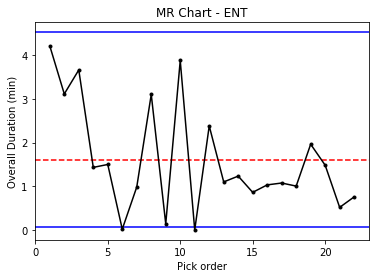

In [88]:
limits = control_limits(MR)
plot = MRchart(limits[0],limits[1],limits[2])
UCL = limits[0]
LCL = limits[1]
Centre = limits[2]

In [89]:
outlier_value, outlier_idx = check_outlier(MRi, UCL, LCL)
if len(outlier_idx) != 0:
    dataset = remove_outlier(outlier_value, outlier_idx)

The MR chart went through 2 iterations, no more outliers!


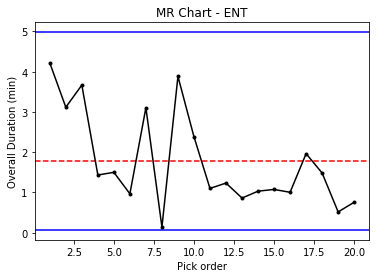

In [90]:
count = 0
while(len(outlier_value) > 0):
    plt.clf()
    count += 1
    #x-axis
    dataset = dataset.reset_index(drop = True)
    MRi, MR = MR_i(dataset)
    #MR = MR_i(dataset)[1]
    x_axis = np.arange(1,len(MRi)+1,1)

    limits = control_limits(MR)
    plot = MRchart(limits[0],limits[1],limits[2])
    UCL = limits[0]
    LCL = limits[1]
    Centre = limits[2]

    outlier_value, outlier_idx = check_outlier(MRi, UCL, LCL)
    if (len(outlier_idx) != 0):
        dataset = remove_outlier(outlier_value, outlier_idx)
print('The MR chart went through ' + str(count) + ' iterations, no more outliers!')
plt.savefig('MR Chart - ENT')

## I Chart

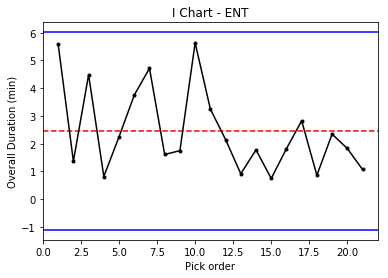

In [91]:
title = 'I Chart - ENT'
#x-axis
x_axis = np.arange(1,len(dataset)+1,1)

limits = I_control_limits(MR, sigma)
UCL = limits[0]
LCL = limits[1]
Centre = limits[2]
Ichart(LCL, UCL, Centre)
plt.savefig('I Chart - ENT')

In [92]:
outlier_value, outlier_idx = I_check_outlier(MRi, UCL, LCL)
if len(outlier_idx) != 0:
    dataset = I_remove_outlier(outlier_value, outlier_idx)

In [93]:
count = 0
while(len(outlier_value) > 0):
    plt.clf()
    count +=1
    #x-axis
    dataset = dataset.reset_index(drop = True)
    MRi, MR = MR_i(dataset)

    x_axis = np.arange(1,len(dataset)+1,1)

    limits = I_control_limits(MR, sigma)
    UCL = limits[0]
    LCL = limits[1]
    Centre = limits[2]
    plot = Ichart(LCL, UCL, Centre)

    outlier_value, outlier_idx = I_check_outlier(MRi, UCL, LCL)
    if len(outlier_idx) != 0:
        dataset = I_remove_outlier(outlier_value, outlier_idx)
print('The I chart went through ' + str(count) + ' iterations, no more outliers!')
# plt.savefig('I Chart - ENT')

The I chart went through 0 iterations, no more outliers!


In [94]:
dataset_ortho_final = dataset
dataset_ortho_final.head()

,OR case #,Overall Duration
0,GOR-2018-7621,335.0
1,GOR-2018-7141,82.0
2,GOR-2018-7761,269.0
3,GOR-2018-7542,49.0
4,GOR-2018-7884,135.0


# Surgical Specialty -- Urology

In [95]:
uro = df[(df['Surgical Specialty'] == 'Urology')]
uro.head()

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,
GOR-2018-6819,2018/6/8,Christina,Cecilia,20 Years,Elective,Urology,1:03 PM,201.0,503.0,NaN
GOR-2018-7092,2018/6/18,Christina,Plenamin,15 Years,Elective,Urology,3:49 PM,247.0,311.0,NaN
GOR-2018-7094,2018/6/18,Christina,Plenamin,15 Years,Elective,Urology,3:49 PM,247.0,311.0,NaN
4 pick sheets,2018/6/7,Jialin,Ella,> 20 Years,Emergency - Gold list,Urology,7:05 AM,NaN,313.0,NaN
GOR-2018-6833,2018/6/26,Christina,Plenamin,15 Years,Elective,Urology,3:32 PM,502.0,502.0,NaN


In [96]:
duplicate_uro = uro[uro.duplicated(['Start Time', 'Disposable Duration', 'Overall Duration'], keep = False)]
duplicate_uro.head()

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,
GOR-2018-7092,2018/6/18,Christina,Plenamin,15 Years,Elective,Urology,3:49 PM,247.0,311.0,NaN
GOR-2018-7094,2018/6/18,Christina,Plenamin,15 Years,Elective,Urology,3:49 PM,247.0,311.0,NaN
GOR-2018-8461,2018/7/3,Jialin,Cecelia,> 20 Years,Emergency,Urology,7:08 AM,186.0,259.0,NaN
GOR-2018-8462,2018/7/3,Jialin,Cecelia,> 20 Years,Emergency,Urology,7:08 AM,186.0,259.0,NaN
GOR-2018-8460,2018/7/3,Jialin,Cecelia,> 20 Years,Emergency,Urology,7:08 AM,186.0,259.0,NaN


In [97]:
#drop duplicates in original dataset
uro = uro.drop(duplicate_uro.index)
uro.head()

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,
GOR-2018-6819,2018/6/8,Christina,Cecilia,20 Years,Elective,Urology,1:03 PM,201.0,503.0,NaN
4 pick sheets,2018/6/7,Jialin,Ella,> 20 Years,Emergency - Gold list,Urology,7:05 AM,NaN,313.0,NaN
GOR-2018-6833,2018/6/26,Christina,Plenamin,15 Years,Elective,Urology,3:32 PM,502.0,502.0,NaN
GOR-2018-7952,2018/6/26,Christina,Plenamin,15 Years,Elective,Urology,3:42 PM,473.0,473.0,NaN
GOR-2018-7717,2018/6/12,Nathan,Cecilia,20 Years,Emergency,Urology,7:08 AM,72.0,72.0,NaN


In [98]:
#number of duplicates in a given day and start time
uro_count = duplicate_uro.groupby(['Date','Start Time'])['Disposable Duration','Overall Duration'].count()
uro_count = uro_count.reset_index().drop(['Disposable Duration'], axis = 1)
uro_count = uro_count.rename(columns={'Overall Duration': 'Counts'})
uro_count

,Date,Start Time,Counts
0,2018/6/12,16:30,2
1,2018/6/18,3:49 PM,2
2,2018/7/3,7:08 AM,3


In [99]:
duplicate_uro = duplicate_uro.drop_duplicates(keep = 'first')
duplicate_uro.head()

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,
GOR-2018-7092,2018/6/18,Christina,Plenamin,15 Years,Elective,Urology,3:49 PM,247.0,311.0,NaN
GOR-2018-8461,2018/7/3,Jialin,Cecelia,> 20 Years,Emergency,Urology,7:08 AM,186.0,259.0,NaN
GOR-2018-7445,2018/6/12,Nathan,Edna,9 years,elective,Urology,16:30,192.0,192.0,NaN


In [100]:
for i in range(len(uro_count['Counts'])):
    for j in range(len(duplicate_uro['Overall Duration'])):
        if uro_count['Date'][i] == duplicate_uro['Date'][j] and uro_count['Start Time'][i] == duplicate_uro['Start Time'][j]:
            duplicate_uro['Disposable Duration'][j] /= uro_count['Counts'][i]
            duplicate_uro['Overall Duration'][j] /= uro_count['Counts'][i]

/Users/jiajialin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/jiajialin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [101]:
duplicate_uro

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,
GOR-2018-7092,2018/6/18,Christina,Plenamin,15 Years,Elective,Urology,3:49 PM,123.5,155.500000,NaN
GOR-2018-8461,2018/7/3,Jialin,Cecelia,> 20 Years,Emergency,Urology,7:08 AM,62.0,86.333333,NaN
GOR-2018-7445,2018/6/12,Nathan,Edna,9 years,elective,Urology,16:30,96.0,96.000000,NaN


In [102]:
uro = pd.concat([uro, duplicate_uro],axis = 0)

In [103]:
title = 'MR Chart - Urology'
dataset = uro['Overall Duration']
normality_check(dataset)

Data is normally distributed


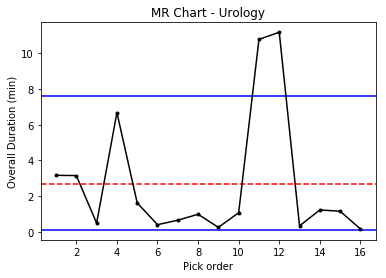

In [104]:
dataset = dataset.reset_index()
#x-axis
MRi = MR_i(dataset)[0]
MR = MR_i(dataset)[1]
x_axis = np.arange(1,len(MRi)+1,1)

limits = control_limits(MR)
plot = MRchart(limits[0],limits[1],limits[2])
UCL = limits[0]
LCL = limits[1]
Centre = limits[2]

In [105]:
outlier_value, outlier_idx = check_outlier(MRi, UCL, LCL)
if len(outlier_idx) != 0:
    dataset = remove_outlier(outlier_value, outlier_idx)

The MR chart went through 5 iterations, no more outliers!


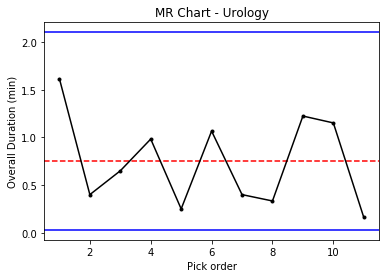

In [106]:
count = 0
while(len(outlier_value) > 0):
    plt.clf()
    count += 1
    #x-axis
    dataset = dataset.reset_index(drop = True)
    MRi, MR = MR_i(dataset)
    x_axis = np.arange(1,len(MRi)+1,1)

    limits = control_limits(MR)
    plot = MRchart(limits[0],limits[1],limits[2])
    UCL = limits[0]
    LCL = limits[1]
    Centre = limits[2]

    outlier_value, outlier_idx = check_outlier(MRi, UCL, LCL)
    if (len(outlier_idx) != 0):
        dataset = remove_outlier(outlier_value, outlier_idx)
print('The MR chart went through ' + str(count) + ' iterations, no more outliers!')
plt.savefig('MR Chart - Urology')

## I Chart

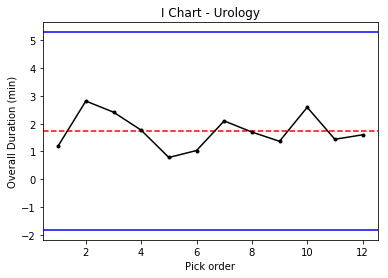

In [107]:
title = 'I Chart - Urology'
#x-axis
x_axis = np.arange(1,len(dataset)+1,1)

limits = I_control_limits(MR, sigma)
UCL = limits[0]
LCL = limits[1]
Centre = limits[2]
plot = Ichart(LCL, UCL, Centre)
plt.savefig('I Chart - Urology')

In [108]:
outlier_value, outlier_idx = I_check_outlier(MRi, UCL, LCL)
if len(outlier_idx) != 0:
    dataset = I_remove_outlier(outlier_value, outlier_idx)

In [109]:
count = 0
while(len(outlier_value) > 0):
    count += 1
    plt.clf()
    dataset = dataset.reset_index(drop = True)
    MRi, MR = MR_i(dataset)

    x_axis = np.arange(1,len(dataset)+1,1)

    limits = I_control_limits(MR, simga)
    UCL = limits[0]
    LCL = limits[1]
    Centre = limits[2]
    Ichart(LCL, UCL, Centre)

    outlier_value, outlier_idx = I_check_outlier(MRi, UCL, LCL)
    if len(outlier_idx) != 0:
        dataset = I_remove_outlier(outlier_value, outlier_idx)
print('The I chart went through ' + str(count) + ' iterations, no more outliers!')
# plt.savefig('I Chart - Urology')

The I chart went through 0 iterations, no more outliers!


In [110]:
dataset_ortho_final = dataset
dataset_ortho_final.head()

,OR case #,Overall Duration
0,GOR-2018-7717,72.0
1,GOR-2018-7755,169.0
2,GOR-2018-7939,145.0
3,GOR-2018-7940,106.0
4,GOR-2018-7942,47.0


# Surgical Specialty -- Gynaecology

In [111]:
gyn = df[(df['Surgical Specialty'] == 'Gynecology')]
gyn.head()

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,
GOR-2018-6110,2018/6/8,Christina,M,Experienced,Elective,Gynecology,3:25 PM,154.0,250.0,NaN
GOR-2018-7573,2018/6/26,Christina,B,> 20 Years,Elective,Gynecology,10:49 AM,161.0,178.0,NaN
GOR-2018-7502,2018/6/26,Christina,B,> 20 Years,Elective,Gynecology,10:53 AM,166.0,219.0,NaN
GOR-2018-6300,2018/7/4,Christina,Cecelia,> 20 Years,elective,Gynecology,11:42 AM,173.0,286.0,NaN
GOR-2018-3410,2018/6/15,Emma,Elaine,15 years,Elective,Gynecology,11:03 AM,160.0,256.0,NaN


In [112]:
duplicate_gyn = gyn[gyn.duplicated(['Start Time', 'Disposable Duration', 'Overall Duration'], keep = False)]
duplicate_gyn.head()

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,
GOR-2018-7457,2018/6/7,Jialin,Ella,> 20 Years,Elective,Gynecology,11:38 AM,372.0,506.0,NaN
GOR-2018-6072,2018/6/7,Jialin,Ella,> 20 Years,Elective,Gynecology,11:38 AM,372.0,506.0,NaN
GOR-2018-7186,2018/6/7,Jialin,Ella,> 20 Years,Elective,Gynecology,11:47 AM,219.0,318.0,NaN
GOR-2018-6075,2018/6/7,Jialin,Ella,> 20 Years,Elective,Gynecology,11:47 AM,219.0,318.0,NaN


In [113]:
#drop duplicates in original dataset
gyn = gyn.drop(duplicate_gyn.index)
gyn.head()

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,
GOR-2018-6110,2018/6/8,Christina,M,Experienced,Elective,Gynecology,3:25 PM,154.0,250.0,NaN
GOR-2018-7573,2018/6/26,Christina,B,> 20 Years,Elective,Gynecology,10:49 AM,161.0,178.0,NaN
GOR-2018-7502,2018/6/26,Christina,B,> 20 Years,Elective,Gynecology,10:53 AM,166.0,219.0,NaN
GOR-2018-6300,2018/7/4,Christina,Cecelia,> 20 Years,elective,Gynecology,11:42 AM,173.0,286.0,NaN
GOR-2018-3410,2018/6/15,Emma,Elaine,15 years,Elective,Gynecology,11:03 AM,160.0,256.0,NaN


In [114]:
#number of duplicates in a given day and start time
gyn_count = duplicate_gyn.groupby(['Date','Start Time'])['Disposable Duration','Overall Duration'].count()
gyn_count = gyn_count.reset_index().drop(['Disposable Duration'], axis = 1)
gyn_count = gyn_count.rename(columns={'Overall Duration': 'Counts'})
gyn_count

,Date,Start Time,Counts
0,2018/6/7,11:38 AM,2
1,2018/6/7,11:47 AM,2


In [115]:
duplicate_gyn = duplicate_gyn.drop_duplicates(keep = 'first')
duplicate_gyn

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,
GOR-2018-7457,2018/6/7,Jialin,Ella,> 20 Years,Elective,Gynecology,11:38 AM,372.0,506.0,NaN
GOR-2018-7186,2018/6/7,Jialin,Ella,> 20 Years,Elective,Gynecology,11:47 AM,219.0,318.0,NaN


In [116]:
for i in range(len(gyn_count['Counts'])):
    for j in range(len(duplicate_gyn['Overall Duration'])):
        if gyn_count['Date'][i] == duplicate_gyn['Date'][j] and gyn_count['Start Time'][i] == duplicate_gyn['Start Time'][j]:
            duplicate_gyn['Disposable Duration'][j] /= gyn_count['Counts'][i]
            duplicate_gyn['Overall Duration'][j] /= gyn_count['Counts'][i]

/Users/jiajialin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/jiajialin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [117]:
duplicate_gyn

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,
GOR-2018-7457,2018/6/7,Jialin,Ella,> 20 Years,Elective,Gynecology,11:38 AM,186.0,253.0,NaN
GOR-2018-7186,2018/6/7,Jialin,Ella,> 20 Years,Elective,Gynecology,11:47 AM,109.5,159.0,NaN


In [118]:
gyn = pd.concat([gyn, duplicate_gyn],axis = 0)

In [119]:
dataset = gyn['Overall Duration']
normality_check(dataset)

Data is normally distributed


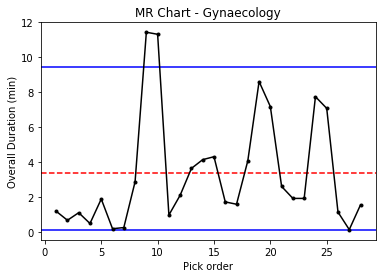

In [120]:
title = 'MR Chart - Gynaecology'
dataset = dataset.reset_index()
#x-axis
MRi = MR_i(dataset)[0]
MR = MR_i(dataset)[1]
x_axis = np.arange(1,len(MRi)+1,1)

limits = control_limits(MR)
plot = MRchart(limits[0],limits[1],limits[2])
UCL = limits[0]
LCL = limits[1]
Centre = limits[2]

In [121]:
outlier_value, outlier_idx = check_outlier(MRi, UCL, LCL)
if len(outlier_idx) != 0:
    dataset = remove_outlier(outlier_value, outlier_idx)

The MR chart went through 3 iterations, no more outliers!


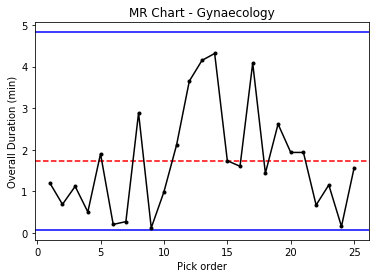

In [122]:
count = 0
while(len(outlier_value) > 0):
    plt.clf()
    count += 1
    #x-axis
    dataset = dataset.reset_index(drop = True)
    MRi, MR = MR_i(dataset)
    #MR = MR_i(dataset)[1]
    x_axis = np.arange(1,len(MRi)+1,1)

    limits = control_limits(MR)
    plot = MRchart(limits[0],limits[1],limits[2])
    UCL = limits[0]
    LCL = limits[1]
    Centre = limits[2]

    outlier_value, outlier_idx = check_outlier(MRi, UCL, LCL)
    if (len(outlier_idx) != 0):
        dataset = remove_outlier(outlier_value, outlier_idx)
print('The MR chart went through ' + str(count) + ' iterations, no more outliers!')
plt.savefig('MR Chart - Gynaecology')

## I Chart

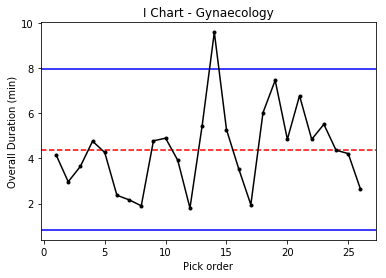

In [123]:
title = 'I Chart - Gynaecology'
#x-axis
x_axis = np.arange(1,len(dataset)+1,1)

limits = I_control_limits(MR, sigma)
UCL = limits[0]
LCL = limits[1]
Centre = limits[2]
plot = Ichart(LCL, UCL, Centre)

In [124]:
outlier_value, outlier_idx = I_check_outlier(MRi, UCL, LCL)
if len(outlier_idx) != 0:
    dataset = I_remove_outlier(outlier_value, outlier_idx)

The I chart went through 1 iterations, no more outliers!


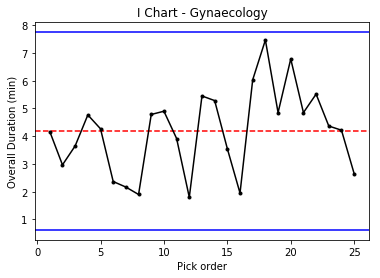

In [125]:
count = 0
while(len(outlier_value) > 0):
    plt.clf()
    count +=1
    #x-axis
    dataset = dataset.reset_index(drop = True)
    MRi, MR = MR_i(dataset)

    x_axis = np.arange(1,len(dataset)+1,1)

    limits = I_control_limits(MR, sigma)
    UCL = limits[0]
    LCL = limits[1]
    Centre = limits[2]
    plot = Ichart(LCL, UCL, Centre)

    outlier_value, outlier_idx = I_check_outlier(MRi, UCL, LCL)
    if len(outlier_idx) != 0:
        dataset = I_remove_outlier(outlier_value, outlier_idx)
print('The I chart went through ' + str(count) + ' iterations, no more outliers!')
plt.savefig('I Chart - Gynaecology')

In [126]:
dataset_ortho_final = dataset
dataset_ortho_final.head()

,OR case #,Overall Duration
0,GOR-2018-6110,250.0
1,GOR-2018-7573,178.0
2,GOR-2018-7502,219.0
3,GOR-2018-6300,286.0
4,GOR-2018-3410,256.0


# Surgical Specialty -- Plastics

In [127]:
plastic = df[(df['Surgical Specialty'] == 'Plastics')]
plastic.head()

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,
GOR-2018-7380,2018/6/18,Christina,Ella,> 20 Years,Elective,Plastics,11:11 AM,163.0,290.0,NaN
GOR-2018-7914,2018/6/18,Christina,Ella,> 20 Years,Elective,Plastics,11:19 AM,137.0,229.0,NaN
GOR-2018-8013,2018/6/26,Christina,B,> 20 Years,Elective,Plastics,10:58 AM,177.0,220.0,NaN
GOR-2018-8333,2018/7/4,Christina,Cecelia,> 20 Years,elective,Plastics,11:37 AM,105.0,255.0,NaN
GOR-2018-8334,2018/7/4,Christina,Cecelia,> 20 Years,elective,Plastics,11:37 AM,160.0,255.0,NaN


In [128]:
duplicate_plastic = plastic[plastic.duplicated(['Start Time', 'Disposable Duration', 'Overall Duration'], keep = False)]
duplicate_plastic

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,
GOR-2018-7193,2018/6/6,Haya,C,20 years,Elective,Plastics,10:54 AM,288.0,400.0,NaN
GOR-2018-7197,2018/6/6,Haya,C,> 20 Years,Elective,Plastics,10:54 AM,288.0,400.0,NaN
GOR-2018-6937,2018/6/25,Jialin,Ella,> 20 Years,elective,Plastics,11:35,112.0,173.0,NaN
GOR-2018-7724,2018/6/25,Jialin,Ella,> 20 Years,elective,Plastics,11:35,112.0,173.0,NaN


In [129]:
#drop duplicates in original dataset
plastic = plastic.drop(duplicate_plastic.index)
plastic.head()

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,
GOR-2018-7380,2018/6/18,Christina,Ella,> 20 Years,Elective,Plastics,11:11 AM,163.0,290.0,NaN
GOR-2018-7914,2018/6/18,Christina,Ella,> 20 Years,Elective,Plastics,11:19 AM,137.0,229.0,NaN
GOR-2018-8013,2018/6/26,Christina,B,> 20 Years,Elective,Plastics,10:58 AM,177.0,220.0,NaN
GOR-2018-8333,2018/7/4,Christina,Cecelia,> 20 Years,elective,Plastics,11:37 AM,105.0,255.0,NaN
GOR-2018-8334,2018/7/4,Christina,Cecelia,> 20 Years,elective,Plastics,11:37 AM,160.0,255.0,NaN


In [130]:
#number of duplicates in a given day and start time
plastic_count = duplicate_plastic.groupby(['Date','Start Time'])['Disposable Duration','Overall Duration'].count()
plastic_count = plastic_count.reset_index().drop(['Disposable Duration'], axis = 1)
plastic_count = plastic_count.rename(columns={'Overall Duration': 'Counts'})
plastic_count

,Date,Start Time,Counts
0,2018/6/25,11:35,2
1,2018/6/6,10:54 AM,2


In [131]:
duplicate_plastic = duplicate_plastic.drop_duplicates(keep = 'first')
duplicate_plastic

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,
GOR-2018-7193,2018/6/6,Haya,C,20 years,Elective,Plastics,10:54 AM,288.0,400.0,NaN
GOR-2018-7197,2018/6/6,Haya,C,> 20 Years,Elective,Plastics,10:54 AM,288.0,400.0,NaN
GOR-2018-6937,2018/6/25,Jialin,Ella,> 20 Years,elective,Plastics,11:35,112.0,173.0,NaN


In [132]:
for i in range(len(plastic_count['Counts'])):
    for j in range(len(duplicate_plastic['Overall Duration'])):
        if plastic_count['Date'][i] == duplicate_plastic['Date'][j] and plastic_count['Start Time'][i] == duplicate_plastic['Start Time'][j]:
            duplicate_plastic['Disposable Duration'][j] /= plastic_count['Counts'][i]
            duplicate_plastic['Overall Duration'][j] /= plastic_count['Counts'][i]

duplicate_plastic

/Users/jiajialin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/jiajialin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/jiajialin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,
GOR-2018-7193,2018/6/6,Haya,C,20 years,Elective,Plastics,10:54 AM,144.0,200.0,NaN
GOR-2018-7197,2018/6/6,Haya,C,> 20 Years,Elective,Plastics,10:54 AM,144.0,200.0,NaN
GOR-2018-6937,2018/6/25,Jialin,Ella,> 20 Years,elective,Plastics,11:35,56.0,86.5,NaN


In [133]:
plastic = pd.concat([plastic, duplicate_plastic],axis = 0)
plastic.head()

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,
GOR-2018-7380,2018/6/18,Christina,Ella,> 20 Years,Elective,Plastics,11:11 AM,163.0,290.0,NaN
GOR-2018-7914,2018/6/18,Christina,Ella,> 20 Years,Elective,Plastics,11:19 AM,137.0,229.0,NaN
GOR-2018-8013,2018/6/26,Christina,B,> 20 Years,Elective,Plastics,10:58 AM,177.0,220.0,NaN
GOR-2018-8333,2018/7/4,Christina,Cecelia,> 20 Years,elective,Plastics,11:37 AM,105.0,255.0,NaN
GOR-2018-8334,2018/7/4,Christina,Cecelia,> 20 Years,elective,Plastics,11:37 AM,160.0,255.0,NaN


In [134]:
dataset = plastic['Overall Duration']
normality_check(dataset)

Data needs to be transformed


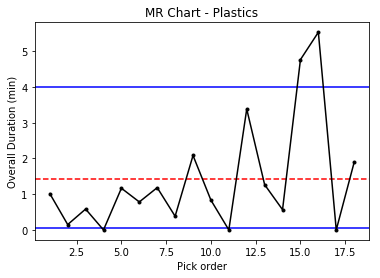

In [135]:
title = 'MR Chart - Plastics'
dataset = dataset.reset_index()
#x-axis
MRi = MR_i(dataset)[0]
MR = MR_i(dataset)[1]
x_axis = np.arange(1,len(MRi)+1,1)

limits = control_limits(MR)
plot = MRchart(limits[0],limits[1],limits[2])
UCL = limits[0]
LCL = limits[1]
Centre = limits[2]

In [136]:
outlier_value, outlier_idx = check_outlier(MRi, UCL, LCL)
if len(outlier_idx) != 0:
    dataset = remove_outlier(outlier_value, outlier_idx)

The MR chart went through 5 iterations, no more outliers!


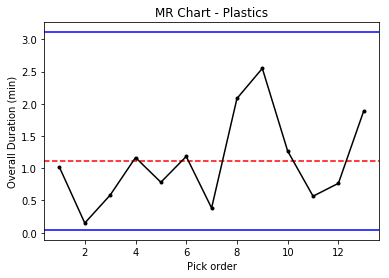

In [137]:
count = 0
while(len(outlier_value) > 0):
    plt.clf()
    count += 1
    #x-axis
    dataset = dataset.reset_index(drop = True)
    MRi, MR = MR_i(dataset)
    #MR = MR_i(dataset)[1]
    x_axis = np.arange(1,len(MRi)+1,1)

    limits = control_limits(MR)
    plot = MRchart(limits[0],limits[1],limits[2])
    UCL = limits[0]
    LCL = limits[1]
    Centre = limits[2]

    outlier_value, outlier_idx = check_outlier(MRi, UCL, LCL)
    if (len(outlier_idx) != 0):
        dataset = remove_outlier(outlier_value, outlier_idx)
print('The MR chart went through ' + str(count) + ' iterations, no more outliers!')
plt.savefig('MR Chart - Plastics')

## I Chart

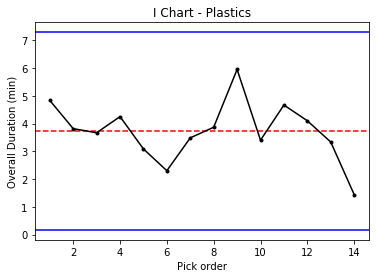

In [138]:
title = 'I Chart - Plastics'
#x-axis
x_axis = np.arange(1,len(dataset)+1,1)

limits = I_control_limits(MR, sigma)
UCL = limits[0]
LCL = limits[1]
Centre = limits[2]
plot = Ichart(LCL, UCL, Centre)
plt.savefig('I Chart - Plastics')

In [139]:
outlier_value, outlier_idx = I_check_outlier(MRi, UCL, LCL)
if len(outlier_idx) != 0:
    dataset = I_remove_outlier(outlier_value, outlier_idx)

In [140]:
count = 0
while(len(outlier_value) > 0): 
    plt.clf()
    count += 1
    #x-axis
    dataset = dataset.reset_index(drop = True)
    MRi, MR = MR_i(dataset)

    x_axis = np.arange(1,len(dataset)+1,1)

    limits = I_control_limits(MR, sigma)
    UCL = limits[0]
    LCL = limits[1]
    Centre = limits[2]
    plot = Ichart(LCL, UCL, Centre)

    outlier_value, outlier_idx = I_check_outlier(MRi, UCL, LCL)
    if len(outlier_idx) != 0:
        dataset = I_remove_outlier(outlier_value, outlier_idx)

print('The I chart went through ' + str(count) + ' iterations, no more outliers!')
# plt.savefig('I Chart - Plastics')

The I chart went through 0 iterations, no more outliers!


In [141]:
dataset_ortho_final = dataset
dataset_ortho_final.head()

,OR case #,Overall Duration
0,GOR-2018-7380,290.0
1,GOR-2018-7914,229.0
2,GOR-2018-8013,220.0
3,GOR-2018-8334,255.0
4,GOR-2018-7655,185.0


# Surgical Specialty -- Ophthalmology

In [142]:
ophtha = df[(df['Surgical Specialty'] == 'Ophthalmology')]
ophtha.shape[0]

2

# Surgical Specialty -- Laparoscopic Cholecystectomy

In [143]:
LC = df[(df['Surgical Specialty'] == 'Laparoscopic Cholecystectomy')]
LC.head()

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,


In [144]:
LC.shape[0]

0

# Surgical Specialty -- Cysto

In [145]:
cysto = df[(df['Surgical Specialty'] == 'Cysto')
           | (df['Surgical Specialty'] == 'cysto')]
cysto.head()

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,
GOR-2018-8253,2018/6/26,Christina,Plenamin,15 Years,Elective,Cysto,3:06 PM,100.0,131.0,NaN
GOR-2018-7398,2018/6/15,Emma,Ann,> 20 Years,Elective,Cysto,3:13 PM,241.0,409.0,NaN
GOR-2018-7794,2018/6/14,Jialin,Elaine,15 years,Emergency - Gold list,Cysto,7:12,100.0,168.0,NaN
GOR-2018-7796,2018/6/14,Jialin,Elaine,15 years,Emergency - Gold list,Cysto,7:12,100.0,168.0,NaN
GOR-2018-7808,2018/6/14,Jialin,Elaine,15 years,Emergency - Gold list,Cysto,7:45,NaN,349.0,NaN


In [146]:
cysto.shape[0]

35

In [147]:
duplicate_cysto = cysto[cysto.duplicated(['Start Time', 'Disposable Duration', 'Overall Duration'], keep = False)]
duplicate_cysto

#drop duplicates in original dataset
cysto = cysto.drop(duplicate_cysto.index)
cysto.head()

#number of duplicates in a given day and start time
cysto_count = duplicate_cysto.groupby(['Date','Start Time'])['Disposable Duration','Overall Duration'].count()
cysto_count = cysto_count.reset_index().drop(['Disposable Duration'], axis = 1)
cysto_count = cysto_count.rename(columns={'Overall Duration': 'Counts'})
cysto_count

duplicate_cysto = duplicate_cysto.drop_duplicates(keep = 'first')
duplicate_cysto

for i in range(len(cysto_count['Counts'])):
    for j in range(len(duplicate_cysto['Overall Duration'])):
        if cysto_count['Date'][i] == duplicate_cysto['Date'][j] and cysto_count['Start Time'][i] == duplicate_cysto['Start Time'][j]:
            duplicate_cysto['Disposable Duration'][j] /= cysto_count['Counts'][i]
            duplicate_cysto['Overall Duration'][j] /= cysto_count['Counts'][i]

duplicate_cysto

cysto = pd.concat([plastic, duplicate_plastic],axis = 0)
cysto.head()

/Users/jiajialin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/jiajialin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,
GOR-2018-7380,2018/6/18,Christina,Ella,> 20 Years,Elective,Plastics,11:11 AM,163.0,290.0,NaN
GOR-2018-7914,2018/6/18,Christina,Ella,> 20 Years,Elective,Plastics,11:19 AM,137.0,229.0,NaN
GOR-2018-8013,2018/6/26,Christina,B,> 20 Years,Elective,Plastics,10:58 AM,177.0,220.0,NaN
GOR-2018-8333,2018/7/4,Christina,Cecelia,> 20 Years,elective,Plastics,11:37 AM,105.0,255.0,NaN
GOR-2018-8334,2018/7/4,Christina,Cecelia,> 20 Years,elective,Plastics,11:37 AM,160.0,255.0,NaN


In [148]:
dataset = cysto['Overall Duration']
normality_check(dataset)

Data is normally distributed


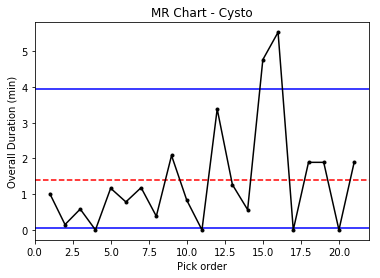

In [149]:
title = 'MR Chart - Cysto'
dataset = dataset.reset_index()
#x-axis
MRi = MR_i(dataset)[0]
MR = MR_i(dataset)[1]
x_axis = np.arange(1,len(MRi)+1,1)

limits = control_limits(MR)
plot = MRchart(limits[0],limits[1],limits[2])
UCL = limits[0]
LCL = limits[1]
Centre = limits[2]

In [150]:
outlier_value, outlier_idx = check_outlier(MRi, UCL, LCL)
if len(outlier_idx) != 0:
    dataset = remove_outlier(outlier_value, outlier_idx)

The MR chart went through 6 iterations, no more outliers!


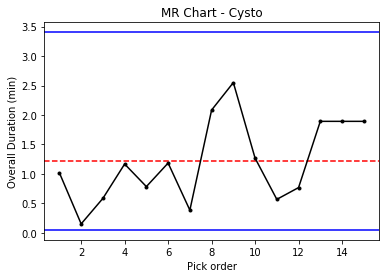

In [151]:
count = 0
while(len(outlier_value) > 0):
    plt.clf()
    count += 1
    #x-axis
    dataset = dataset.reset_index(drop = True)
    MRi, MR = MR_i(dataset)
    #MR = MR_i(dataset)[1]
    x_axis = np.arange(1,len(MRi)+1,1)

    limits = control_limits(MR)
    plot = MRchart(limits[0],limits[1],limits[2])
    UCL = limits[0]
    LCL = limits[1]
    Centre = limits[2]

    outlier_value, outlier_idx = check_outlier(MRi, UCL, LCL)
    if (len(outlier_idx) != 0):
        dataset = remove_outlier(outlier_value, outlier_idx)
print('The MR chart went through ' + str(count) + ' iterations, no more outliers!')
plt.savefig('MR Chart - Cysto')

## I Chart

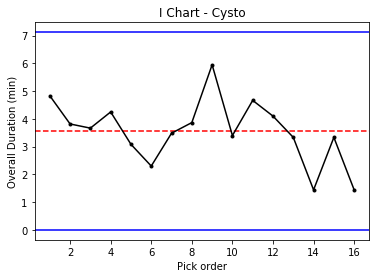

In [152]:
title = 'I Chart - Cysto'
#x-axis
x_axis = np.arange(1,len(dataset)+1,1)

limits = I_control_limits(MR, sigma)
UCL = limits[0]
LCL = limits[1]
Centre = limits[2]
plot = Ichart(LCL, UCL, Centre)
plt.savefig('I Chart - Cysto')

In [153]:
outlier_value, outlier_idx = I_check_outlier(MRi, UCL, LCL)
if len(outlier_idx) != 0:
    dataset = I_remove_outlier(outlier_value, outlier_idx)

In [154]:
count = 0 
while(len(outlier_value) > 0):
    plt.clf()
    count += 1
    #x-axis
    dataset = dataset.reset_index(drop = True)
    MRi, MR = MR_i(dataset)

    x_axis = np.arange(1,len(dataset)+1,1)

    limits = I_control_limits(MR, sigma)
    UCL = limits[0]
    LCL = limits[1]
    Centre = limits[2]
    plot = Ichart(LCL, UCL, Centre)

    outlier_value, outlier_idx = I_check_outlier(MRi, UCL, LCL)
    if len(outlier_idx) != 0:
        dataset = I_remove_outlier(outlier_value, outlier_idx)
    
print('The I chart went through ' + str(count) + ' iterations, no more outliers!')
# plt.savefig('I Chart - Cysto')

The I chart went through 0 iterations, no more outliers!


In [155]:
dataset_ortho_final = dataset
dataset_ortho_final.head()

,OR case #,Overall Duration
0,GOR-2018-7380,290.0
1,GOR-2018-7914,229.0
2,GOR-2018-8013,220.0
3,GOR-2018-8334,255.0
4,GOR-2018-7655,185.0


# Surgical Specialty -- Lapidectomy

In [156]:
lapid = df[(df['Surgical Specialty'] == 'Lapidectomy')]
lapid.head()

,Date,Name of Observer,Name of Picker,Picker's Year(s) of Experience,Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest,Surgical Specialty,Start Time,Disposable Duration,Overall Duration,Distractions
OR case #,,,,,,,,,,


In [157]:
lapid.shape[0]

0